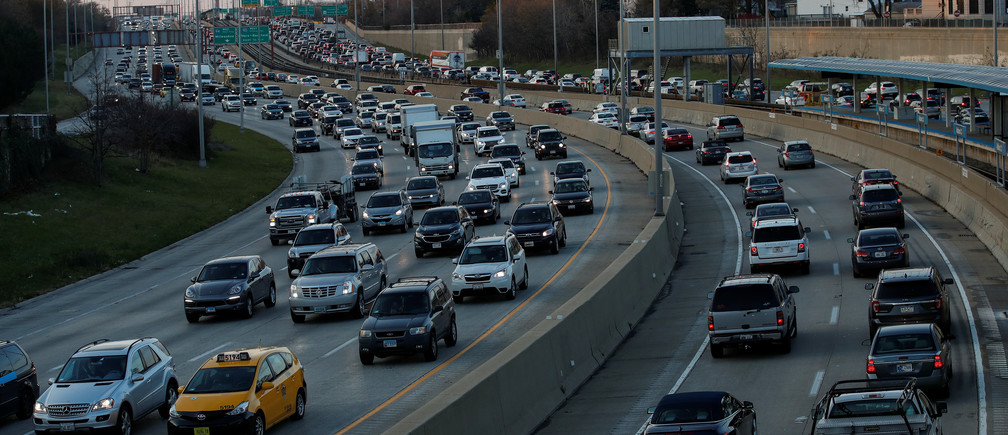

<center>Please Upvote if this Kernel helps beacause upvote motivate me to update.<center> 

### About this Competion
For the March edition of the 2022 Tabular Playground Series you're challenged to forecast twelve-hours of traffic flow in a U.S. metropolis. The time series in this dataset are labelled with both location coordinates and a direction of travel -- a combination of features that will test your skill at spatio-temporal forecasting within a highly dynamic traffic network

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.stats import mode

from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv')
test=pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv')

## Data Content:
`train.csv` - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.

**This train data contain several columns:**

- `row_id` - a unique identifier for this instance
- `time` - the 20-minute period in which each measurement was taken
- `x` - the east-west midpoint coordinate of the roadway
- `y` - the north-south midpoint coordinate of the roadway
- `direction` - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
- `congestion` - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.

In [ ]:
train.head()

### Exploring Train Data

In [ ]:
print('Number of rows in train data:', train.shape[0])
print('Number of columns in train data:', train.shape[1])
print('Number of values in train data:', train.count().sum())
print('Number missing values in train data:', sum(train.isna().sum()))

Check the basic statisrics for each columns on Count, mean, standard deviation, minimum, 1st quartile, median, 3rd quartile and maximum

In [ ]:
train.describe().T.head()

In [ ]:
train.dtypes

In [ ]:
train.nunique().to_frame()

In [ ]:
# check duplicates values
duplicates_train = train.duplicated().sum()
print("Duplicate Values", duplicates_train)

## EDA

In [ ]:
print(train['direction'].unique())
print(test['direction'].unique())

`row_id` is not necessary for that reason we can drop this from our train data.

In [ ]:
train.drop(["row_id"] , axis = 1 , inplace = True)
test.drop(["row_id"] , axis = 1 , inplace = True)

Just checkout some statistics stuff like mean,min and parcentile.

In [ ]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#F8766D')\
                     .bar(subset=["mean",], color='#00BFC4')

In [ ]:
#check nuls values
train.isnull().sum().to_frame()

Why not check the relation between Direction and congestion. lets check

In [ ]:
a=train['direction']
plt.figure(figsize=(22,10))
ax= sns.countplot(a,label='count')
EB,NB,SB,WB,NE,SW,NW,SE=a.value_counts()
print("mNumber of EB ", EB)
print("mNumber of NB ", NB)
print("Number of WB", WB)
print("95mNumber of SW", SW)
print("Number of SE", SE)

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % train['congestion'].skew())
print("Kurtosis: %f" % train['congestion'].kurt())

In [ ]:
train['congestion'].describe()

In [ ]:
plt.hist(train['congestion'])

In [ ]:
##Correlation
v=3
corr=train.corr()
colmn = corr.nlargest(v, 'congestion')['congestion'].index 
xm = np.corrcoef(train[colmn].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(18, 18))
hm = sns.heatmap(xm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=colmn.values, xticklabels=colmn.values)
plt.show()

## Feature Engineering

In [ ]:
encoded_vals = {
    'NB': 0,
    'NE': 1,
    'EB': 2,
    'SE': 3,
    'SB': 4,
    'SW': 5,
    'WB': 6, 
    'NW': 7,
}

train['direction'] = train['direction'].map(encoded_vals)
test['direction'] = test['direction'].map(encoded_vals)

In [ ]:
def make_date_features(df, column='time', drop_column=True):
    df['datetime'] = pd.to_datetime(df[column])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df = df.drop(['datetime'], axis=1)
    if drop_column:
        df = df.drop([column], axis=1)
    return df 

train_df = make_date_features(train)
train_df = train_df.drop(['year'], axis=1) # Because the 'year' column only contains '1991'.

test_df = make_date_features(test)
test_df = test_df.drop(['year'], axis=1)

train_df.head()

In [ ]:
def add_feature(df):
    df['direcmon']=df['direction'] * df['month']
    df['direcmon']=df.groupby('x')['direcmon'].cumsum()
    
    df['dir_cumsum'] = (df['x']).groupby(df['direction']).cumsum()
    
    df['direcday']=df['direction'] * df['day']
    df['direcday']=df.groupby('x')['direcday'].cumsum()
    
    df['day_cumsum'] = (df['x']).groupby(df['direction']).cumsum()
    
    
    df['direction_x__max'] = df.groupby(['direction'])['x'].transform('max')
    df['direction_x__max'] = df.groupby(['direction'])['y'].transform('max')
    

    
    df['x__dir__diffmax'] = df.groupby(['direction'])['x'].transform('max') - df['x']
    df['x__dir_diffmean'] = df.groupby(['direction'])['x'].transform('mean') - df['x']
    
    df['x__dir__diffmax'] = df.groupby(['direction'])['y'].transform('max') - df['y']
    df['y__dir_diffmean'] = df.groupby(['direction'])['y'].transform('mean') - df['y']
    
    df = pd.get_dummies(df)
    return df
    
    
train_df=add_feature(train_df)
test_df=add_feature(test_df)

In [ ]:
X = train_df.copy()
y = X.pop('congestion')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=2021 )

In [ ]:
train_X = X_train.to_numpy()
# y_train =y_train.to_numpy()
test_X =X_test.to_numpy()
# y_test =y_test.to_numpy()
test =test_df.to_numpy()

### XGBRegressor

XGBoost Parameter Tuning: Folow the link for more details. https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [ ]:
global_seed = 42
from xgboost import plot_importance

In [ ]:
# instantiate the classifier 
xgb = XGBRegressor(objective='reg:linear', seed=global_seed)
eval_set=[(train_X, y_train),(test_X,y_test),]
xgb.fit(train_X, y_train,
          early_stopping_rounds=200,
          eval_set=eval_set,
          eval_metric='mae',
          verbose=True)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,12))
plot_importance(xgb,ax=ax, xlabel=None)
plt.title('XGB Feature importance')
plt.show()

In [ ]:
results = xgb.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.legend()

plt.ylabel('MAE')
plt.title('XGBoost MAE')
plt.show()

### Submission

In [ ]:
pred = xgb.predict(test_df)
submission['congestion'] = pred
submission.to_csv('submission.csv', index=False)
submission.head()

<center> More Update is comming. Dont forget to upVote. <b>Thanks<b> Btw <center> 